_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Summer term 2021

Lecture Date: 2021-04-15
Due date: 2021-04-26, 9am

Date Started: 2024-04-21
Date Completed: 2024-04-??

Student names: Tanmay Bishnoi

# Coding Lab 1

- Filter Signal
- Detect Action Potentials
- Extract Waveforms
- Extract Features using PCA

Download the data file ```nda_ex1.csv``` from ILIAS and save it in a subfolder ```../data/```.

In [1]:
import  pandas as pd
import  seaborn as sns
import  matplotlib.pyplot as plt
import  numpy as np
from    scipy import signal
from    sklearn.decomposition import PCA
import  scipy as sp
import  itertools as it
sns.set_style('whitegrid')
%matplotlib inline


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load data

The recording contains extracellular recordings from 4 channels. Details of the experimental procedure were given during the lecture.

In [2]:
Fs = 30000     # sampling rate of the signal in Hz
dt = 1/Fs
gain = .5      # gain of the signal
x = pd.read_csv('../data/nda_ex_1.csv', header=0, names=('Ch1', 'Ch2', 'Ch3', 'Ch4'))  
x

,Ch1,Ch2,Ch3,Ch4
0,-141,-184,-316,-191
1,-136,-167,-290,-196
2,-168,-185,-306,-219
3,-147,-188,-332,-219
4,-165,-196,-331,-206
...,...,...,...,...
19199994,1023,1075,1230,1110
19199995,1034,1054,1229,1112
19199996,1006,1058,1239,1118
19199997,977,1092,1235,1125


In [3]:
x.describe()

,Ch1,Ch2,Ch3,Ch4
count,1.920000e+07,1.920000e+07,1.920000e+07,1.920000e+07
mean,3.600331e+00,-8.850918e-01,2.864284e-01,2.210982e+00
std,5.824474e+02,6.014818e+02,6.464363e+02,6.126105e+02
min,-3.607000e+03,-3.739000e+03,-3.871000e+03,-3.750000e+03
25%,-3.460000e+02,-3.610000e+02,-3.950000e+02,-3.640000e+02
50%,1.200000e+01,8.000000e+00,-1.000000e+00,1.000000e+01
75%,3.650000e+02,3.720000e+02,4.010000e+02,3.810000e+02
max,2.873000e+03,3.004000e+03,3.099000e+03,3.017000e+03


## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filterSignal()```. A typical choice for this task would be a butterworth filter. Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings. Hint: Make sure to use a filter that compensates for phase shifting.

*Grading: 2 pts*


In [4]:
# Filter raw signal
def filterSignal(
                    x       : pd.DataFrame, 
                    Fs      : float, 
                    low     : float, 
                    high    : float,
                    ) -> pd.DataFrame:
#   y = filterSignal(x, Fs, low, high) filters the signal x. Each column in x is one
#   recording channel. Fs is the sampling frequency. low and high specify the passband in Hz.
#   The filter delay is compensated in the output y.
    def create_butterworth_bandpass(
                                        lowcut  : float, 
                                        highcut : float, 
                                        fs      : float, 
                                        order   : int=5) -> tuple:
        # https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
        # according to NyQuist criterion we must have measured\
        # the signal with 2*N freq for the waveform to be true.
        nyq     = 0.5 * fs
        low     = lowcut/nyq
        high    = highcut/nyq
        b,a     = signal.butter(order, [low, high], btype='band')
        return (a,b)
        
    a,b = create_butterworth_bandpass(low,high,Fs)
    y = pd.DataFrame( {col: pd.Series( signal.lfilter(b, a, x[col].to_list()), index=x.index ) for col in x.columns})

    return y

xf = filterSignal(x, Fs, 500, 4000)
# TODO: scan literature to find the most used low/high cutoff for bandpass filter

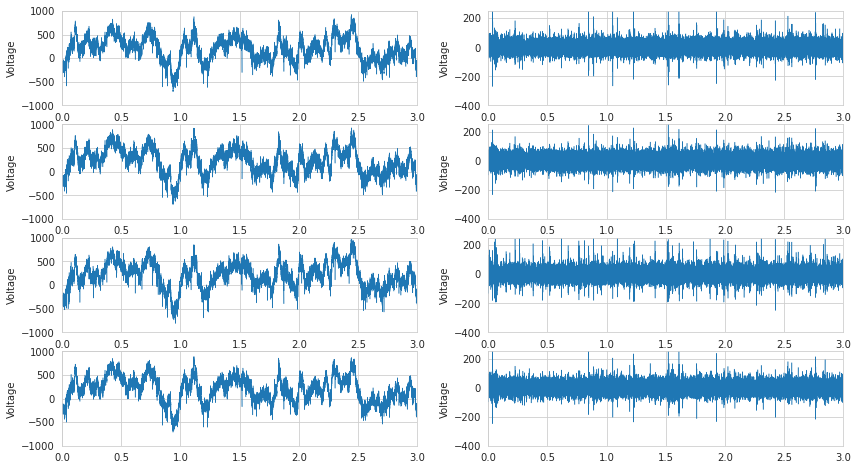

In [5]:
plt.figure(figsize=(14, 8))

T = 100000
t = np.arange(0,T) * dt 

for i, col in enumerate(xf):
    plt.subplot(4,2,2*i+1)
    plt.plot(t,x[col][0:T].to_list(),linewidth=.5)
    plt.ylim((-1000, 1000))
    plt.xlim((0,3))
    plt.ylabel('Voltage')
    
    
    plt.subplot(4,2,2*i+2)
    plt.plot(t,xf[col][0:T].to_list(),linewidth=.5)
    plt.ylim((-400, 250))
    plt.xlim((0,3))
    plt.ylabel('Voltage')
    

## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detectSpikes()``` . Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes. Plot the threshold. Are the detected time points well aligned with peaks in the signal? Hint: Pay attention to the sign of the signal, what does it mean that it's an extracellular recording?

*Grading: 3 pts*

In [12]:
# Detect spikes
# s, t = detectSpikes(x,Fs) detects spikes in x, where Fs the sampling
#   rate (in Hz). The outputs s and t are column vectors of spike times in
#   samples and ms, respectively. By convention the time of the zeroth
#   sample is 0 ms.

def detectSpikes(
                    x   : np.array,
                    Fs  : float
                    ) -> tuple:

    dt = 1/Fs


    def threshold_channel(x:pd.Series) -> pd.Series:
        # threshold = (x.mean() - x.std()/0.6745)
        threshold = -((x - x.median()).abs()).median()/0.6745
        print(f'threshold: {threshold}')
        return x<threshold

    def get_times(mask, Fs)-> np.array:
        return mask[mask].index.to_numpy() * (1/Fs)


    s = dict()
    t = dict()

    for i, col in enumerate(x):
        s_ = threshold_channel(x[col])
        s[col] = s_

        t_ = get_times(s_, Fs)
        t[col] = t_

    s   = pd.DataFrame(s)

    return (s, t)


T = xf.shape[0]
s, t = detectSpikes(xf,Fs)


threshold: -35.637327384177354
threshold: -37.4661783001373
threshold: -38.162009651050596
threshold: -36.1738620244363


In [14]:
plt.figure(figsize=(7, 8))

tt = np.arange(0,T) * dt 

for i, col in enumerate(xf):
    plt.subplot(4,1,i+1)
    plt.plot(tt,xf[col].values,linewidth=.5)
    plt.plot(tt[s[col].values],xf[col][s[col]].values,'r.')
    plt.ylim((-400, 400))
    plt.xlim((0.025,0.075))
    plt.ylabel('Voltage')



: 

In [11]:
xf['Ch1'].mean()

4.401930965052568e-06

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extractWaveforms()```. Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected. Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 2 pts*

In [ ]:
def extractWaveforms(x, s):
# Extract spike waveforms.
#   w = extractWaveforms(x, s) extracts the waveforms at times s (given in
#   samples) from the filtered signal x using a fixed window around the
#   times of the spikes. The return value w is a 3d array of size
#   length(window) x #spikes x #channels.


    return w
    

In [ ]:
w = extractWaveforms(xf.as_matrix(),s)

Plot first 100 spike waveforms, include 10 ms before the peak, and 20 ms after.

In [ ]:
t = np.arange(-10,20) * dt * 1000 

plt.figure(figsize=(11, 8))

for i, col in enumerate(xf):
    plt.subplot(2,2,i+1)
    plt.plot(t,w[:,1:100,i],'k', linewidth=1)
    plt.ylim((-500, 250))
    plt.xlim((-0.33,0.66))
    plt.ylabel('Voltage')


Plot largest 100 spike waveforms, include 10 ms before the peak, and 20 ms after.

In [ ]:
idx = np.argsort(np.min(np.min(w,axis=2),axis=0))


t = np.arange(-10,20) * dt * 1000 

plt.figure(figsize=(11, 8))
for i, col in enumerate(xf):
    plt.subplot(2,2,i+1)
    plt.plot(t,w[:,idx[0:100],i],'k', linewidth=1)
    plt.ylim((-1000, 500))
    plt.xlim((-0.33,0.66))
    plt.ylabel('Voltage')


## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extractFeatures()```. You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs.
Plot scatter plots for all pairwise combinations of 1st PCs. Do you see clusters visually? 

*Grading: 2+1 pts*


In [ ]:
def extractFeatures(w):
# Extract features for spike sorting.
#   b = extractFeatures(w) extracts features for spike sorting from the
#   waveforms in w, which is a 3d array of size length(window) x #spikes x
#   #channels. The output b is a matrix of size #spikes x #features.
#   The implementation should do PCA on the waveforms of each channel
#   separately and uses the first three principal components. Thus, we get
#   a total of 12 features. Also, the varianced explained by the 3 features per channel
#   should be computed.
    

    

    return b



In [ ]:
b = extractFeatures(w)

In [ ]:
plt.figure(figsize=(10, 6))
plt.suptitle('Scatter plots',fontsize=20)

idx = [0, 3, 6, 9]
p = 1
labels = ['Ch1','Ch2','Ch3','Ch4']
for i in np.arange(0,4):
    for j in np.arange(i+1,4):
        ax = plt.subplot(2,3,p, aspect='equal')
        plt.plot(b[:,idx[i]],b[:,idx[j]],'.k', markersize=.7) 
        plt.xlabel(labels[i])
        plt.ylabel(labels[j])
        plt.xlim((-1500,1500))
        plt.ylim((-1500,1500))
        ax.set_xticks([])
        ax.set_yticks([])
        p = p+1

In [ ]:
np.save('../data/nda_ex_1_features',b)
np.save('../data/nda_ex_1_spiketimes',s)
np.save('../data/nda_ex_1_waveforms',w)

## TODO: Use AutoEncoder for Clustering